|평가문항	|상세기준|
|:-|:-|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.	|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|

In [1]:
# 필요 패키지 호출

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 불러오기

In [2]:
# CSV 파일 로드
k_chatbot = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData.csv')

# 데이터 확인
k_chatbot.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [3]:
k_chatbot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


총 11823개의 데이터가 들어있으며, 결측치는 없다.

# 2. 데이터 전처리
## 2.1 띄어쓰기 전처리


In [4]:
# pip install --upgrade git+https://github.com/haven-jeon/PyKoSpacing.git

In [5]:
# 라이브러리 호출
from pykospacing import Spacing
spacing = Spacing()

# 데이터에 띄어쓰기 적용
k_chatbot['Q'] = k_chatbot['Q'].apply(lambda x: spacing(x))
k_chatbot['A'] = k_chatbot['A'].apply(lambda x: spacing(x))

k_chatbot.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1 지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌 푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안 돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지 ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시 간 낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시 간 낭비인데 자꾸 보게 됨,시간을 정하고 해보세요.,0


뭔가 묘하게 띄어쓰기가 된 것 같긴 하지만(눈살이 찌푸려지죠.->눈살이 찌 푸려지죠.)  
아무튼 띄어쓰기 전처리 완료

## 2.2 형태소 분리

In [6]:
tokenizer = Mecab()

def preprocess_sentence(sentence):
    sentence = tokenizer.morphs(sentence)
    sentence = ' '.join(sentence)
    return sentence

k_chatbot['Q'] = k_chatbot['Q'].apply(preprocess_sentence)
k_chatbot['A'] = k_chatbot['A'].apply(preprocess_sentence)

k_chatbot.head(10)

,Q,A,label
0,12 시 땡 !,하루 가 또 가 네요 .,0
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .,0
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
4,PPL 심하 네,눈살 이 찌 푸 려 지 죠 .,0
5,SD 카드 망가졌 어,다시 새로 사 는 게 마음 편해요 .,0
6,SD 카드 안 돼,다시 새로 사 는 게 마음 편해요 .,0
7,SNS 맞 팔 왜 안 하 지 ㅠㅠ,잘 모르 고 있 을 수 도 있 어요 .,0
8,SNS 시 간 낭비 인 거 아 는데 매일 하 는 중,시간 을 정하 고 해 보 세요 .,0
9,SNS 시 간 낭비 인데 자꾸 보 게 됨,시간 을 정하 고 해 보 세요 .,0


## 2.3 반복 문자 제거
챗봇이 대답하는 데 큰 영향을 미치지 않는 'ㅋㅋㅋ', 'ㅎㅎㅎ'와 같이 반복 문자를 제거한다.  
우선 반복 문자가 있는지 확인.

In [7]:
# 반복 문자를 포함하는 문장 찾기
def count_repeated_characters(data, pattern):
    # 문장 중에서 주어진 패턴을 포함하는 경우를 필터링
    contains_pattern = data[data.str.contains(pattern, regex=True, na=False)]
    return contains_pattern

# 'ㅋ+', 'ㅎ+', 'ㅠ+' 등의 패턴 정의
patterns = [r'ㅋ{1,}', r'ㅎ{1,}', r'ㅠ{1,}']

for pattern in patterns:
    # 질문(Q)에서 패턴을 포함하는 문장 수 확인
    repeated_in_q = count_repeated_characters(k_chatbot['Q'], pattern)
    print(f"질문에서 '{pattern}' 패턴을 포함하는 문장 수:", len(repeated_in_q))

    # 답변(A)에서 패턴을 포함하는 문장 수 확인
    repeated_in_a = count_repeated_characters(k_chatbot['A'], pattern)
    print(f"답변에서 '{pattern}' 패턴을 포함하는 문장 수:", len(repeated_in_a))

질문에서 'ㅋ{1,}' 패턴을 포함하는 문장 수: 7
답변에서 'ㅋ{1,}' 패턴을 포함하는 문장 수: 0
질문에서 'ㅎ{1,}' 패턴을 포함하는 문장 수: 11
답변에서 'ㅎ{1,}' 패턴을 포함하는 문장 수: 0
질문에서 'ㅠ{1,}' 패턴을 포함하는 문장 수: 46
답변에서 'ㅠ{1,}' 패턴을 포함하는 문장 수: 1


In [8]:
# 'ㅋ', 'ㅎ', 'ㅠ' 문자 제거
def remove_characters(sentence):
    sentence = re.sub(r'[ㅋㅎㅠ]', '', sentence)  # 'ㅋ', 'ㅎ', 'ㅠ'를 찾아서 제거
    return sentence

# 데이터에 문자 제거 적용
k_chatbot['Q'] = k_chatbot['Q'].apply(remove_characters)
k_chatbot['A'] = k_chatbot['A'].apply(remove_characters)

# 결과 확인
k_chatbot.head(10)

,Q,A,label
0,12 시 땡 !,하루 가 또 가 네요 .,0
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .,0
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
4,PPL 심하 네,눈살 이 찌 푸 려 지 죠 .,0
5,SD 카드 망가졌 어,다시 새로 사 는 게 마음 편해요 .,0
6,SD 카드 안 돼,다시 새로 사 는 게 마음 편해요 .,0
7,SNS 맞 팔 왜 안 하 지,잘 모르 고 있 을 수 도 있 어요 .,0
8,SNS 시 간 낭비 인 거 아 는데 매일 하 는 중,시간 을 정하 고 해 보 세요 .,0
9,SNS 시 간 낭비 인데 자꾸 보 게 됨,시간 을 정하 고 해 보 세요 .,0


7번 인덱스의 'SNS 맞 팔 왜 안 하 지 ㅠㅠ'가 'SNS 맞 팔 왜 안 하 지'로 변경된 것을 확인할 수 있다.

## 2.4 불용어처리
[불용어 목록 참고 링크](https://www.ranks.nl/stopwords/korean)

In [9]:
# 불용어 파일 경로
file_path = '~/aiffel/transformer_chatbot/data/stopword.txt'
file_path = os.path.expanduser(file_path)  # 홈 디렉토리 확장

# 불용어 리스트 불러오기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = [line.strip() for line in file.readlines()]
    return stopwords

# 불용어 리스트 생성
stopwords = load_stopwords(file_path)
len(stopwords)

675

In [10]:
# 불용어 제거 함수
def remove_stopwords(sentence):
    tokens = sentence.split(' ')
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return ' '.join(filtered_tokens)

# 데이터에 불용어 제거 적용
k_chatbot['Q'] = k_chatbot['Q'].apply(remove_stopwords)
k_chatbot['A'] = k_chatbot['A'].apply(remove_stopwords)

# 결과 확인
k_chatbot

,Q,A,label
0,12 시 땡 !,하루 네요 .,0
1,1 지망 학교 떨어졌,위로 해 드립니다 .,0
2,3 박 4 놀 러 고 싶 다,여행 은 언제나 좋 죠 .,0
3,3 박 4 정도 놀 러 고 싶 다,여행 은 언제나 좋 죠 .,0
4,PPL 심하,눈살 찌 푸 려 지 죠 .,0
...,...,...,...
11818,훔쳐 보 는 도 눈치 보임 .,티 니까 눈치 보이 는 거 죠 !,2
11819,훔쳐 보 는 도 눈치 보임 .,훔쳐 보 는 거 티나 봐요 .,2
11820,흑기사 해 주 는 짝 남 .,설 렜 겠 어요 .,2
11821,힘든 연애 좋 은 연애 라는 게 차이 일까 ?,잘 헤어질 수 있 는 사이 인 거 같 아요 .,2


불용어가 제거되었다.

# 3. 단어장 만들기

In [11]:
import tensorflow_datasets as tfds

# 불용어 처리가 완료된 질문과 답변 데이터셋 준비
questions = k_chatbot['Q'].tolist()
answers = k_chatbot['A'].tolist()

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print("단어장의 크기:", VOCAB_SIZE)

START_TOKEN의 번호 : [7957]
END_TOKEN의 번호 : [7958]
단어장의 크기: 7959


# 4. 각 단어를 고유한 정수로 인코딩 & 패딩

In [13]:
# 각 문장을 토큰화하여 길이를 측정
question_lengths = [len(sentence.split()) for sentence in questions]
answer_lengths = [len(sentence.split()) for sentence in answers]

# 평균 길이와 최대 길이 계산
avg_question_length = sum(question_lengths) / len(question_lengths)
max_question_length = max(question_lengths)
avg_answer_length = sum(answer_lengths) / len(answer_lengths)
max_answer_length = max(answer_lengths)

print(f"질문 평균 길이: {avg_question_length}")
print(f"질문 최대 길이: {max_question_length}")
print(f"답변 평균 길이: {avg_answer_length}")
print(f"답변 최대 길이: {max_answer_length}")

질문 평균 길이: 5.440835659308128
질문 최대 길이: 29
답변 평균 길이: 6.845386111815952
답변 최대 길이: 30


In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30
print(MAX_LENGTH)

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

30
단어장의 크기 : 7959
필터링 후의 질문 샘플 개수: 11819
필터링 후의 답변 샘플 개수: 11819


In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# TensorFlow 텐서로 변환
questions_tensor = tf.convert_to_tensor(questions, dtype=tf.int64)
answers_tensor = tf.convert_to_tensor(answers, dtype=tf.int64)

# 디코더 입력과 타깃 생성
decoder_inputs = answers_tensor[:, :-1]
decoder_targets = answers_tensor[:, 1:]

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices(({
    'inputs': questions_tensor,
    'dec_inputs': decoder_inputs
}, {
    'outputs': decoder_targets
}))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 5. 모델 정의 및 학습하기

In [16]:
# 트랜스포머 구축에 필요한 함수 정의

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스킹 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [17]:
# 트랜스포머 함수 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 5.1 모델 생성

In [18]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13542912    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

# 5.2 손실함수

In [19]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

## 5.3 커스텀된 학습률

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

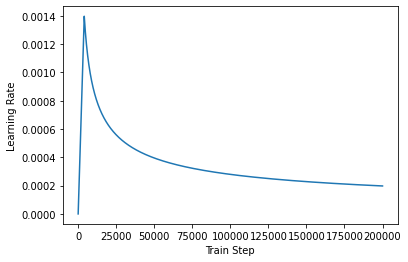

In [21]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있음.

## 5.4 모델 컴파일

In [22]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 5.5 훈련하기

In [23]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_255' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_332075/1981353874.py", line 2, in <module>
      model.fit(dataset, epochs=EPOCHS, verbose=1)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_255'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_255}}]] [Op:__inference_train_function_1518572]